In [1]:
!pip install -qU torch_snippets
!pip install torch-summary
from google.colab import drive
import os
import sys

drive.mount('/content/gdrive')
!ls gdrive/MyDrive/waste-project/
py_file_location = "gdrive/MyDrive/waste-project/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
data1		     model_fpn_v2.pth  processed	   src
generate_data.ipynb  model_v3.pth      resnet50_model.pth  waste_project.ipynb


# Illegal Waste Detection using Faster R-CNN


### Introduction

Illegal waste dumping poses significant environmental and health risks. Identifying and cleaning up can significantly reduce soil, water, and air pollution. These sites often contain hazardous materials that can leach into the ground and contaminate water sources, harm wildlife, and affect the surrounding ecosystem. People living near illegal dumpsites are at risk of exposure to hazardous substances, which can lead to serious health issues like respiratory problems, skin irritations, and even cancer. Detecting these sites helps in minimizing these risks.The process of detecting and cleaning up illegal dumpsites can be resource-intensive and costly. This project aims to leverage computer vision techniques to automatically detect and locate dumpsites, enabling prompt intervention and responsible waste management.


### Problem Statement

This project focuses on the detection and localization of illegal waste dumpsites using the Faster R-CNN (Region-based Convolutional Neural Network) approach. The goal is to provide an efficient and accurate solution for identifying areas with unauthorized waste disposal.

## Project Objectives
<ul>
<li>Collect and curate a comprehensive dataset of images that includes a variety of dumpsites, including image annotation and preprocessing.</li>

<li>Design and implement an Faster R-CNN based model to accurately detect illegal waste dumpsites.
<ul>
  <li>Utilizes the Faster R-CNN algorithm for object detection.</li>
  <li>Precisely identifies the position of illegal waste dumpsites within images.</li>
</ul>
</li>

<li>Conduct thorough training of the model using the prepared dataset</li>

<li>Validate the model using separate test data to evaluate its performance and accuracy.</li>
</ul>


> <img src='/content/gdrive/MyDrive/waste-project/data1/detect_imag.png' alt='?' style='width:900px'/> Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

###  Data Scope

In this project, we leverage two distinct datasets to address the challenge of illegal waste detection from satellite imagery. Our primary dataset originates from the Global Dumpsite Test Data https://www.scidb.cn/en/s/6bq2M3, which is a comprehensive compilation derived from various cities worldwide, including Colombo in Sri Lanka, Dhaka in Bangladesh, Guwahati in India, Kinshasa in the Democratic Republic of Congo, Lagos in Nigeria, New Delhi in India, and several cities in China. The images within this dataset are of size 1024 × 1024 pixels and have been meticulously labeled, classifying dumpsites into categories such as domestic waste, construction waste, agricultural waste, and covered waste. For our specific project, we aggregated these diverse classifications into a singular "dumpsite" class. The dataset is well-structured and provides a valuable resource for training our model on a variety of waste scenarios.

As our second source of data, we turn to the AerialWaste dataset https://aerialwaste.org/, specifically curated for the discovery of illegal landfills. This dataset captures the visual heterogeneity of scenes featuring waste dumps in aerial images, presenting a diverse array of objects within waste deposits. In this context, we consider non-dumpsite images from the AerialWaste dataset to constitute our second class. Effectively, we frame our problem as a binary classification task, distinguishing between images containing illegal waste dumpsites and those representing other scenes within the realm of waste disposal.

By combining these two datasets, we aim to enhance the robustness of our model, ensuring its effectiveness in identifying and localizing illegal waste dumpsites from varying perspectives and contexts.


In [2]:
sys.path.append(os.path.abspath(py_file_location))
from src.data import DumpsiteDataset
from src.model import *
from src.visualize import *
from src.metric import *
import torch
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms
from torch_snippets import *
from torchsummary import summary
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
root_dir = "gdrive/MyDrive/waste-project/processed"
torch. __version__

'2.1.0+cu121'

### Dataset Structure:

The dataset follows a structured organization with images stored in the 'images' directory and corresponding annotations in the 'annotations' directory. Each image is associated with a text file containing information about the location and classification of dumpsites.

### PyTorch Dataset Class:

To seamlessly integrate this dataset into our dumpsite detection pipeline, we've implemented the DumpsiteDataset class using PyTorch. This class efficiently loads images and their corresponding annotations, preprocesses them, and returns a PyTorch-compatible format. It allows for customization through optional transformation functions for both images and targets.

### Key Features:

- **Image Preprocessing:** Images are resized to a common size and normalized.
- **Annotation Processing:** Annotations are loaded and processed, converting relative coordinates to absolute coordinates.
- **Custom Collation Function:** A custom collation function is defined to filter out samples with no valid bounding boxes.
- **PyTorch Compatibility:** The dataset is designed to seamlessly integrate with PyTorch's data loading utilities.

### Usage:

Instantiate the `DumpsiteDataset` class by providing the root directory, optional transformation functions, and a common image size. The dataset can then be easily integrated into PyTorch data loaders for model training and evaluation.

This dataset, combined with the versatility of our PyTorch dataset class, forms the cornerstone of our dumpsite detection project, allowing us to build and train robust models for identifying and localizing illegal waste dumpsites.


In [3]:
# Initialize the custom dataset
dumpsite_dataset = DumpsiteDataset(root_dir)

# Define the size of the training and validation sets
train_size = int(0.8 * len(dumpsite_dataset))
val_size = len(dumpsite_dataset) - train_size
train_dataset, val_dataset = random_split(dumpsite_dataset, [train_size, val_size])

# Print the lengths of the train and val datasets
print("Length of Train Dataset:", len(train_dataset))
print("Length of Validation Dataset:", len(val_dataset))

label2target = {}
label2target['no_dumpsite'] = 0
label2target['dumpsite'] = 1
target2label = {t:l for l,t in label2target.items()}
num_classes = len(label2target)

# Print the number of classes and label-to-target/target-to-label mappings
print("Number of Classes:", num_classes)

Length of Train Dataset: 5432

Length of Validation Dataset: 1358

Number of Classes: 2

### The Dataset Distribution:

The dataset comprises two classes: "dumpsite" and "no_dumpsite."

In [ ]:
def extract_labels(dataset, target2label):
    labels = []
    for sample in dataset:
        if sample is not None:
            _, target = sample
            labels.extend(target2label[label] for label in target['labels'].cpu().detach().numpy())
    return labels

train_labels = extract_labels(train_dataset, target2label)
val_labels = extract_labels(val_dataset, target2label)

In [ ]:
generate_label_statistics(train_labels, val_labels)

+-------------+----------+--------------+------------+-------------+-----------+
| Label       |   Images |   Train imgs | Train(%)   |   Test imgs | Test(%)   |
+=============+==========+==============+============+=============+===========+
| dumpsite    |     4046 |         3247 | 80.25%     |         799 | 19.75%    |
+-------------+----------+--------------+------------+-------------+-----------+
| no_dumpsite |     3395 |         2696 | 79.41%     |         699 | 20.59%    |
+-------------+----------+--------------+------------+-------------+-----------+
| TOTAL       |     7441 |         5943 | 100.00%    |        1498 | 100.00%   |
+-------------+----------+--------------+------------+-------------+-----------+


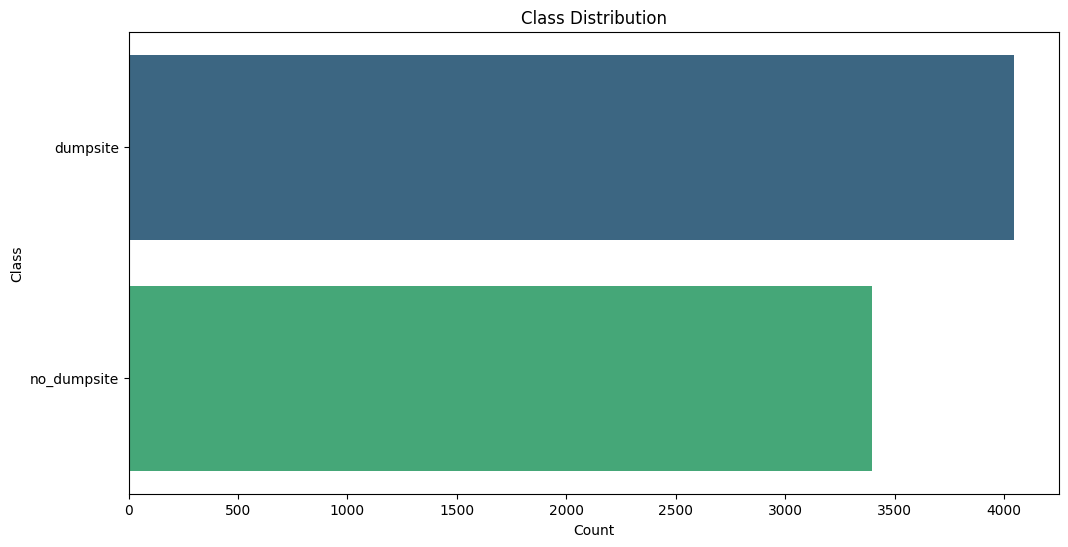

In [ ]:
plot_class_distribution(train_labels, val_labels)


The balanced distribution of both classes in the training and testing sets is designed to foster a robust model training process and facilitate an effective evaluation of the model's performance on unseen data. The percentages provided reflect the proportional representation of each class within their respective dataset splits. The accompanying barplot visually depicts the distribution of the two class labels.

Notably, the barplot may exhibit a higher frequency of the "dumpsite" class compared to "no_dumpsite." This discrepancy arises from instances where some images contain multiple dumpsites. In such cases, each individual dumpsite contributes to the count for the "dumpsite" class, potentially leading to a skewed distribution in the visual representation. Despite this, the underlying dataset structure ensures a fair and comprehensive assessment of the model's ability to discern both classes, contributing to a thorough evaluation of its performance on diverse scenarios.

### Visualization


In [4]:
train_data_loader = DataLoader(train_dataset, batch_size=16,collate_fn=dumpsite_dataset.collate_fn, shuffle=True)
val_data_loader = DataLoader(val_dataset,collate_fn=dumpsite_dataset.collate_fn, batch_size=16) #32

In [ ]:
for ix, (images, targets) in enumerate(train_data_loader):
    if ix == 1:  # Break after processing 3 batches
        break

    images = [im for im in images]
    targets = [tar for tar in targets]

    for ix, output in enumerate(targets):
        bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
        labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
        show(images[ix].cpu().permute(1, 2, 0), bbs=bbs, texts=labels, sz=15)

# Display the grid layout
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
labels = []
images, targets= next(iter(train_data_loader))

for image in images:
    print("Image Shape:", image.shape)
    break

for target in targets:
    boxes = target['boxes']
    label = target['labels']
    labels.extend(label)
    print("Bounding Boxes Shape:", boxes.shape)
    print("Labels:", labels)
    break

Image Shape:
torch.Size([3, 1024, 1024])

Bounding Boxes Shape:
torch.Size([1, 4])

Labels:
[tensor(0)]

###  A Summary of Object Detection and Localization Methods

Object detection and localization are critical tasks in computer vision, involving the identification of objects within an image and determining their locations. Several methods have been developed, each with its strengths and limitations. Here's a summary of some prominent techniques:

#### 1. Region Proposal Methods
- **Description**: These methods, like Selective Search, generate potential object regions (proposals) in an image. These regions are then classified into object categories.
- **Strengths**: They can detect objects at various scales and are flexible in identifying a wide range of objects.
- **Limitations**: Generally slow due to the high number of regions generated, and the subsequent classification of each region.

#### 2. R-CNN (Region-based Convolutional Neural Networks)
- **Description**: R-CNN applies high-capacity CNNs to the region proposals to perform classification and bounding box regression.
- **Strengths**: Offers high accuracy in object detection due to deep learning features.
- **Limitations**: Computationally intensive and slow, as it processes each region proposal separately. Also, the training process is multi-stage and complex.

#### 3. Fast R-CNN
- **Description**: An improvement over R-CNN, Fast R-CNN uses a shared CNN for all region proposals, extracting features before applying region proposals.
- **Strengths**: Faster than R-CNN as it avoids redundant computations on the same regions and integrates classification and bounding box regression into a single model.
- **Limitations**: Still relies on external region proposal methods, which can be a bottleneck.



### Addressing Limitations: Faster R-CNN
Faster R-CNN was developed to address the limitations of its predecessors. It introduces the Region Proposal Network (RPN), effectively merging the region proposal and object detection tasks into a single network.

- **Region Proposal Network (RPN)**: RPN is a fully convolutional network that predicts object bounds and objectness scores at each position. It's fast and efficient.
- **Integration with Fast R-CNN**: The proposals generated by RPN are directly fed into Fast R-CNN for classification and bounding box regression.
- **Strengths of Faster R-CNN**:
  - **Speed**: It's significantly faster than Fast R-CNN as it eliminates the need for a separate region proposal algorithm.
  - **Accuracy**: Maintains high accuracy in detecting and localizing objects.
  - **End-to-End Training**: Offers a streamlined training process as both RPN and Fast R-CNN can be trained together.


**Key Components:**

1. **Region Proposal Network (RPN):**
   - Generates region proposals or candidate bounding boxes for potential objects in the image.
   - Utilizes anchor boxes with different scales and aspect ratios as reference boxes for proposal generation.

2. **Region of Interest (RoI) Pooling:**
   - Aligns features within each proposal to a fixed spatial size using RoI pooling.
   - Ensures consistent dimensions for features from different proposals.

3. **Feature Pyramid Network (FPN):**
   - Enhances feature representation at multiple scales by integrating features from different levels of the convolutional hierarchy.

4. **Classifier and Bounding Box Regressor:**
   - RoI features are passed through a classifier for predicting class probabilities and a bounding box regressor for refining bounding box coordinates.



### Summary of Parameters
- **Total Parameters**: 41,299,161, highlighting the model's complexity and capacity.
- **Trainable Parameters**: 41,076,761, indicating the parts of the model that were fine-tuned during training.
- **Non-trainable Parameters**: 222,400, representing frozen layers that were not updated during training.



In [ ]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 15
log = Report(n_epochs)

# Print summary
summary(model)

Layer (type:depth-idx)                             Param #
├─GeneralizedRCNNTransform: 1-1                    --
├─BackboneWithFPN: 1-2                             --
|    └─IntermediateLayerGetter: 2-1                --
|    |    └─Conv2d: 3-1                            (9,408)
|    |    └─FrozenBatchNorm2d: 3-2                 --
|    |    └─ReLU: 3-3                              --
|    |    └─MaxPool2d: 3-4                         --
|    |    └─Sequential: 3-5                        (212,992)
|    |    └─Sequential: 3-6                        1,212,416
|    |    └─Sequential: 3-7                        7,077,888
|    |    └─Sequential: 3-8                        14,942,208
|    └─FeaturePyramidNetwork: 2-2                  --
|    |    └─ModuleList: 3-9                        984,064
|    |    └─ModuleList: 3-10                       2,360,320
|    |    └─LastLevelMaxPool: 3-11                 --
├─RegionProposalNetwork: 1-3                       --
|    └─AnchorGenerator: 2-3    

Layer (type:depth-idx)                             Param #
├─GeneralizedRCNNTransform: 1-1                    --
├─BackboneWithFPN: 1-2                             --
|    └─IntermediateLayerGetter: 2-1                --
|    |    └─Conv2d: 3-1                            (9,408)
|    |    └─FrozenBatchNorm2d: 3-2                 --
|    |    └─ReLU: 3-3                              --
|    |    └─MaxPool2d: 3-4                         --
|    |    └─Sequential: 3-5                        (212,992)
|    |    └─Sequential: 3-6                        1,212,416
|    |    └─Sequential: 3-7                        7,077,888
|    |    └─Sequential: 3-8                        14,942,208
|    └─FeaturePyramidNetwork: 2-2                  --
|    |    └─ModuleList: 3-9                        984,064
|    |    └─ModuleList: 3-10                       2,360,320
|    |    └─LastLevelMaxPool: 3-11                 --
├─RegionProposalNetwork: 1-3                       --
|    └─AnchorGenerator: 2-3    

# Faster R-CNN Architecture Report

Here, we provide a concise breakdown of the key components of the Faster R-CNN architecture.

## Transform Module

The `transform` module handles the preprocessing of input images. It includes operations such as normalization and resizing to ensure a consistent format for the neural network.

## Backbone: BackboneWithFPN

The `backbone` is responsible for feature extraction. In this case, it utilizes a ResNet-based architecture with a Feature Pyramid Network (FPN). The backbone consists of multiple layers, each composed of bottleneck blocks, facilitating the extraction of hierarchical features at different scales.

## Feature Pyramid Network (FPN)

The FPN enhances the model's ability to detect objects at various scales by creating a feature pyramid from the backbone's intermediate layers. This enables the model to capture both fine-grained and coarse information, improving object localization.

## Region Proposal Network (RPN)

The `rpn` module generates region proposals by utilizing anchor boxes and predicting their likelihood of containing an object (`cls_logits`) and refining their coordinates (`bbox_pred`). The RPN effectively narrows down the regions of interest for subsequent processing.

## RoI (Region of Interest) Heads

The `roi_heads` module performs the final stages of object detection. It extracts features from the proposed regions, applies ROI pooling, and utilizes a two-layer perceptron (`box_head`) for further feature refinement. The final predictions, including class scores (`cls_score`) and bounding box adjustments (`bbox_pred`), are made by the `box_predictor`.

## Total Parameters

The model has a total of 41,299,161 parameters, making it a relatively large and expressive network. Each parameter corresponds to the weights and biases in different layers of the network.

## Selected Parameters

A selection of parameters is listed below, showcasing the diversity in sizes across the network's layers:

- `backbone.body.conv1.weight`: [64, 3, 7, 7]
- `backbone.body.layer1.0.conv1.weight`: [64, 64, 1, 1]
- `backbone.fpn.inner_blocks.0.0.bias`: [256]
- `roi_heads.box_head.fc6.weight`: [1024, 12544]
- `roi_heads.box_predictor.cls_score.weight`: [2, 1024]

This summary provides a glimpse into the complexity and richness of the Faster R-CNN architecture, combining feature extraction, region proposal, and final prediction stages to achieve state-of-the-art object detection performance.


## Model Training

The codes below outline the training loop. The training loop iterates over 15 number of epochs (n_epochs). During each epoch, the model is trained on the training dataset (train_data_loader), and its performance is evaluated on the validation dataset (val_data_loader). For each epoch, the training and validation datasets are processed in batches. The loop iterates through each batch and performs the following steps:


Forward Pass: The inputs from the training batch are fed forward through the model.

Loss Computation: The training loss is computed, and individual losses for different components (classifier, box regression, objectness, and RPN box regression) are extracted.

Backward Pass and Optimization: Gradients are computed with respect to the loss, and the model parameters are updated using  stochastic gradient descent.

Validation Phase
Forward Pass: Similar to the training phase, the inputs from the validation batch are passed through the model.
Loss Computation: The validation loss is computed, and individual losses for different components are extracted.
Logging and Reporting
The training loop logs and reports various metrics during training and validation, including total loss, localization loss, regression loss, objectness loss, and RPN box regression loss. These metrics are recorded for each batch and displayed dynamically.

Saving Model
After each epoch, the model's state dictionary is saved to a file (model_epoch_{epoch+1}.pth). This allows for the preservation of the model's parameters at different training stages, facilitating future use or continuation of training.

Reporting Averages
At specific intervals (every fifth of the total epochs), average metrics are reported, summarizing the model's performance over that period.

In [ ]:
for epoch in range(n_epochs):
    _n = len(train_data_loader)
    for ix, inputs in enumerate(train_data_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(val_data_loader)
    for ix,inputs in enumerate(val_data_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

    # Save the model after each epoch
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')

EPOCH: 2.000  val_regr_loss: 0.061  val_loss: 0.119  trn_loc_loss: 0.042  trn_objectness_loss: 0.013  val_objectness_loss: 0.010  val_loc_loss: 0.040  trn_rpn_box_reg_loss: 0.008  val_rpn_box_reg_loss: 0.008  trn_loss: 0.121  trn_regr_loss: 0.057  (2515.23s - 10060.92s remaining)
EPOCH: 4.000  val_regr_loss: 0.056  val_loss: 0.111  trn_loc_loss: 0.034  trn_objectness_loss: 0.008  val_objectness_loss: 0.009  val_loc_loss: 0.038  trn_rpn_box_reg_loss: 0.007  val_rpn_box_reg_loss: 0.008  trn_loss: 0.105  trn_regr_loss: 0.056  (5020.18s - 7530.27s remaining)
EPOCH: 6.000  val_regr_loss: 0.054  val_loss: 0.102  trn_loc_loss: 0.029  trn_objectness_loss: 0.007  val_objectness_loss: 0.008  val_loc_loss: 0.035  trn_rpn_box_reg_loss: 0.006  val_rpn_box_reg_loss: 0.007  trn_loss: 0.094  trn_regr_loss: 0.051  (7524.92s - 5016.61s remaining)
EPOCH: 8.000  val_regr_loss: 0.051  val_loss: 0.098  trn_loc_loss: 0.026  trn_objectness_loss: 0.006  val_objectness_loss: 0.007  val_loc_loss: 0.033  trn_rpn_


### *Renark on why we used the model.train() in the validate batch*

In evaluation mode, Faster R-CNN returns predictions, not losses. However, we need the losses for monitoring, we have to handle this differently, by following the approach below:

<ul>
<li>Ensure Model Outputs Losses: For the model to return losses, it must be in training mode. However, this contradicts typical validation practices. A workaround is to temporarily set the model to training mode just for the forward pass to compute losses and then set it back to evaluation mode. This is a workaround specific to certain types of models, like Faster R-CNN, which behave differently in training and evaluation modes.
</li>

<li>
No Gradient Calculation: Make sure to wrap the loss computation code in with torch.no_grad(): to ensure that gradients are not calculated during validation.</li>
</ul>



### *What happens if we set the model.train() in the validate_batch*

Since the Faster RCNN model output the predictions in the evaluatiion mode, if we set the mode to train, we will have an error message. The error message we encountered indicates that the losses object returned by the model(input, targets) call in the validate_batch function is a list, not a dictionary. This is unusual for a training step with Faster R-CNN, as it typically returns a dictionary of losses. This issue can occur if the model is in evaluation mode during the validation step, which it should be.







### Losses

val_loc_loss: Validation localization loss. This typically measures how well the model is performing in predicting the exact locations of objects in the validation set.

trn_loc_loss: Training localization loss. Similar to validation localization loss but calculated on the training set.

val_loss: Combined validation loss. This includes both localization and classification losses.

trn_regr_loss: Training regression loss. It measures how well the model is predicting the regression targets (e.g., bounding box coordinates) on the training set.

trn_rpn_box_reg_loss: Training region proposal network (RPN) box regression loss. This is a specific type of loss related to the region proposal network.

val_rpn_box_reg_loss: Validation RPN box regression loss. Similar to the training RPN box regression loss but calculated on the validation set.

trn_objectness_loss: Training objectness loss. This measures how well the model is predicting whether an object is present in a given region on the training set.

val_objectness_loss: Validation objectness loss. Similar to the training objectness loss but calculated on the validation set.

trn_loss: Total training loss. The sum of all individual losses during training.

val_regr_loss: Validation regression loss. Measures how well the model is predicting the regression targets on the validation set.

100%|██████████| 111/111 [00:00<00:00, 692.75it/s]


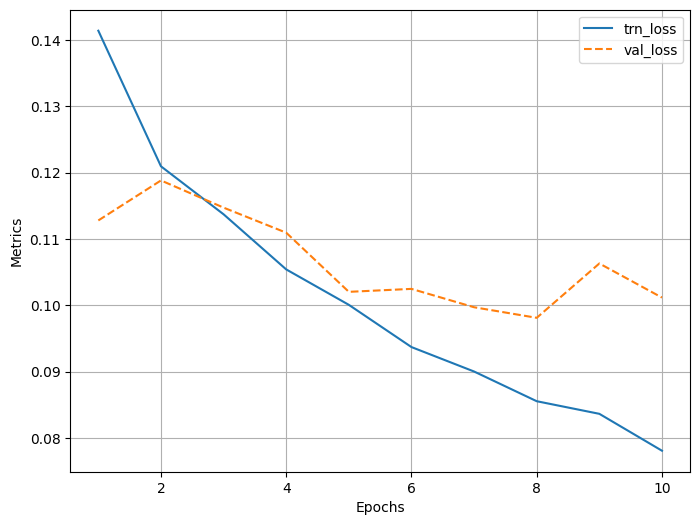

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

100%|██████████| 111/111 [00:00<00:00, 675.23it/s]


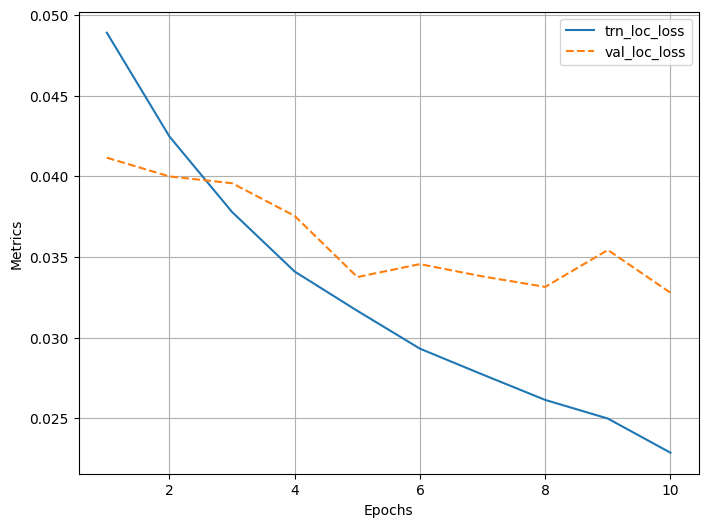

In [ ]:
log.plot_epochs(['trn_loc_loss','val_loc_loss'])

100%|██████████| 111/111 [00:00<00:00, 701.01it/s]


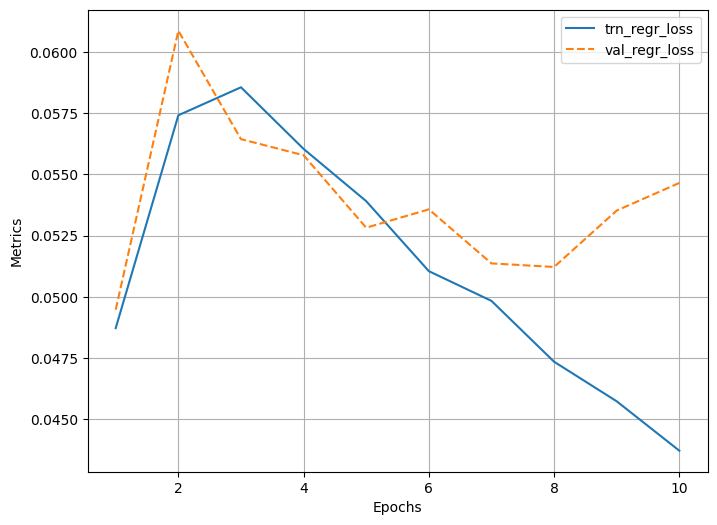

In [ ]:

log.plot_epochs(['trn_regr_loss','val_regr_loss'])

100%|██████████| 111/111 [00:00<00:00, 638.10it/s]


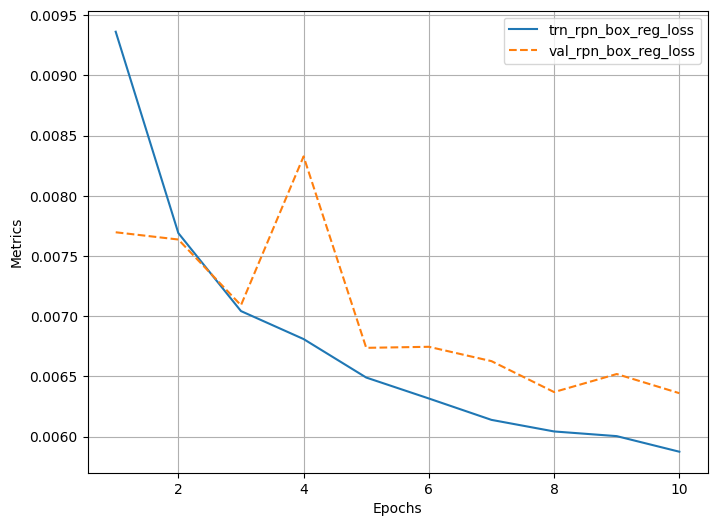

In [ ]:

log.plot_epochs(['trn_rpn_box_reg_loss','val_rpn_box_reg_loss'])

100%|██████████| 111/111 [00:00<00:00, 692.71it/s]


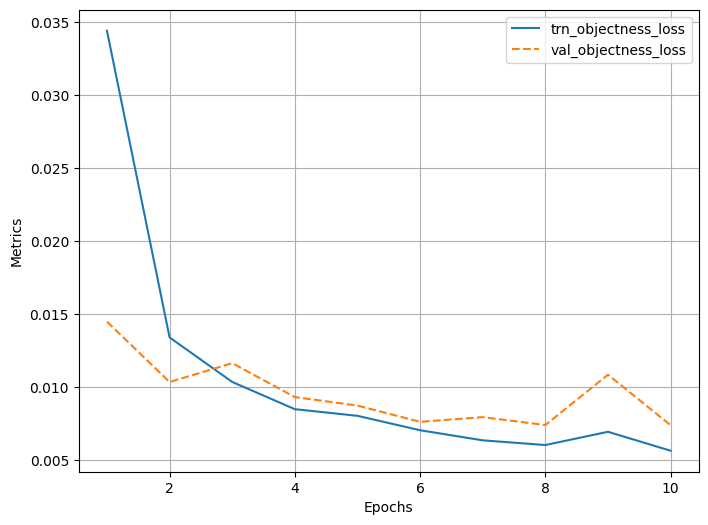

In [ ]:

log.plot_epochs(['trn_objectness_loss','val_objectness_loss'])

Monitoring individual losses (loc_loss, regr_loss, objectness_loss, rpn_box_reg_loss) helps diagnose specific aspects of model performance.

## Overall Observations:

- Decreasing training and validation losses over epochs are positive signs, indicating that the model is learning and generalizing well.The model is progressively improving, with decreasing losses in subsequent epochs.

- Consistent performance in both training and validation is a positive sign of generalization.

In [ ]:
# Save the entire model
torch.save(model.to('cpu').state_dict(), 'gdrive/MyDrive/waste-project/resnet50_model.pth')

#  Evaluation Metrics Model Inference and

To understand the trained model performance the following metrics are used on the test data,  which is the dataset which the model have nopt been exposed to:

### Confidence
- **Definition:** Confidence (confs) refers to the probability assigned by a model to a prediction. It indicates how certain the model is that a detected object belongs to a particular class.
- **Usage:** Used to filter or rank detections. Higher confidence scores are typically associated with more accurate detections.

### Mean Intersection over Union (mIoU)
- **Definition:**  mIoU, it stands for "mean Intersection over Union". It is a metric used to evaluate the accuracy of an object detector on a particular dataset. Specifically, it measures the average overlap between the predicted bounding boxes and the ground truth bounding boxes. The IoU (Intersection over Union) for a single pair of predicted and ground truth bounding boxes is calculated as the area of overlap between the two boxes divided by the area of union of the two boxes. The mIoU is the mean of these IoU values across all predictions and ground truths in the dataset.

- **Significance:** mIoU is a key metric in evaluating the accuracy of object detectors, particularly in how well they localize objects. A higher mIoU indicates better performance in terms of correctly capturing the size and position of objects.

### Precision
- **Definition:** Precision is the ratio of true positives (correctly detected objects) to the total number of positive predictions (sum of true positives and false positives).
- **Importance:** It indicates the model's ability to return only relevant instances. High precision means that the model returns more relevant results than irrelevant.

### Recall
- **Definition:** Recall, also known as sensitivity, is the ratio of true positives to the total number of actual positives (sum of true positives and false negatives).
- **Relevance:** It measures the model's ability to detect all relevant cases. High recall means that the model detects most of the actual positives.


In [5]:
# Load the saved model
weights_reloaded = torch.load('gdrive/MyDrive/waste-project/resnet50_model.pth')

# Instantiate your model
my_model = get_model().to(device)

# Load the state dictionary into your model
my_model.load_state_dict(weights_reloaded)

<All keys matched successfully>

In [ ]:
root_dir = "gdrive/MyDrive/waste-project/processed/test/"
test_dataset = DumpsiteDataset(root_dir)
test_data_loader = DataLoader(test_dataset, batch_size=5,collate_fn=dumpsite_dataset.collate_fn, shuffle=True)

Output hidden; open in https://colab.research.google.com to view.

In [6]:
evaluate_and_display(val_data_loader, my_model, decode_output, target2label, calculate_precision_recall, calculate_mean_iou, custom_show)

**Remark:** If there are no objects (predicted_empty), mIoU is set to np.nan as it's not meaningful to calculate IoU when there are no predictions or ground truth objects.

In [ ]:
accuracy, precision, recall, f1_score, TP, FP, FN = calculate_overall_metrics(val_data_loader, my_model, decode_output, target2label)
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}")

Accuracy: 0.34, Precision: 0.51, Recall: 0.51, F1 Score: 0.51

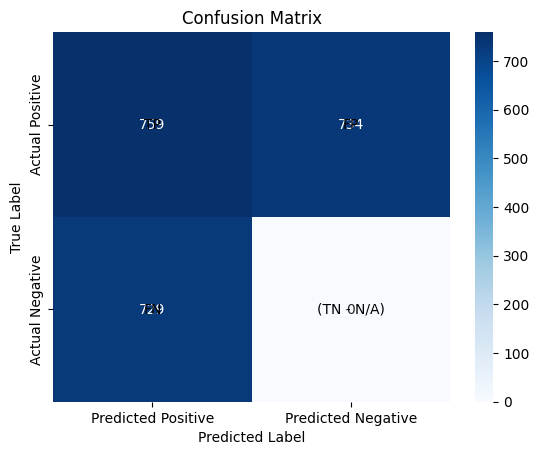

In [ ]:
plot_confusion_matrix(TP, FP, FN)

In the context of object detection, especially with multiple objects per image, the concept of True Negatives (TN) is not straightforward as it is in binary classification tasks. In binary classification, TN represents the number of correctly identified negative cases. However, in object detection, a negative case would imply an area where no object is present, which is practically innumerable and thus not usually counted.

For object detection models, TP, FP, and FN are the primary metrics used for evaluation. TN doesn't have a clear definition as it would involve considering every possible location where an object could have been incorrectly detected but wasn't, which is a much more complex and less informative metric in this context.

## MobileNet v3 in Faster R-CNN Framework

The MobileNet v3 model, when adapted for use in an R-CNN (Region-based Convolutional Neural Network) framework, presents a powerful architecture for object detection tasks. The key components of this architecture are:

### GeneralizedRCNNTransform
- This module handles the preprocessing of input images, preparing them for subsequent processing in the neural network.

### BackboneWithFPN (Feature Pyramid Network)
- The BackboneWithFPN is the core of the MobileNet v3 model, enhanced with a Feature Pyramid Network. It consists of several layers and components:
  - **IntermediateLayerGetter**: Extracts feature maps from various stages of the network.
  - **Conv2dNormActivation**: Applies convolution, normalization, and activation functions.
  - **InvertedResidual Blocks**: A series of inverted residual blocks, characteristic of MobileNet v3, are used to efficiently process feature maps.
  - **FeaturePyramidNetwork**: Enhances the feature extraction process by combining feature maps at different scales, improving the model's ability to detect objects at various sizes.

### Region Proposal Network (RPN)
- The RPN generates object proposals from the feature maps. It includes:
  - **AnchorGenerator**: Generates anchor boxes at multiple scales and aspect ratios.
  - **RPNHead**: Predicts objectness scores and refinements for the anchor boxes.

### RoIHeads
- The Region of Interest (RoI) heads process the proposed regions from the RPN. Key components include:
  - **MultiScaleRoIAlign**: Aligns the proposed regions to a fixed size, enabling consistent processing.
  - **TwoMLPHead**: Applies two fully connected layers to extract features from the aligned regions.
  - **FastRCNNPredictor**: Provides the final object classification and bounding box regression.





In [ ]:
model_v3 = get_mobilenet_v3().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 10
log = Report(n_epochs)

# Print summary
summary(model_v3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 180MB/s]


Layer (type:depth-idx)                             Param #
├─GeneralizedRCNNTransform: 1-1                    --
├─BackboneWithFPN: 1-2                             --
|    └─IntermediateLayerGetter: 2-1                --
|    |    └─Conv2dNormActivation: 3-1              (432)
|    |    └─InvertedResidual: 3-2                  (400)
|    |    └─InvertedResidual: 3-3                  (3,136)
|    |    └─InvertedResidual: 3-4                  (4,104)
|    |    └─InvertedResidual: 3-5                  (9,960)
|    |    └─InvertedResidual: 3-6                  (20,432)
|    |    └─InvertedResidual: 3-7                  (20,432)
|    |    └─InvertedResidual: 3-8                  30,960
|    |    └─InvertedResidual: 3-9                  33,800
|    |    └─InvertedResidual: 3-10                 31,096
|    |    └─InvertedResidual: 3-11                 31,096
|    |    └─InvertedResidual: 3-12                 212,280
|    |    └─InvertedResidual: 3-13                 383,208
|    |    └─Invert

Layer (type:depth-idx)                             Param #
├─GeneralizedRCNNTransform: 1-1                    --
├─BackboneWithFPN: 1-2                             --
|    └─IntermediateLayerGetter: 2-1                --
|    |    └─Conv2dNormActivation: 3-1              (432)
|    |    └─InvertedResidual: 3-2                  (400)
|    |    └─InvertedResidual: 3-3                  (3,136)
|    |    └─InvertedResidual: 3-4                  (4,104)
|    |    └─InvertedResidual: 3-5                  (9,960)
|    |    └─InvertedResidual: 3-6                  (20,432)
|    |    └─InvertedResidual: 3-7                  (20,432)
|    |    └─InvertedResidual: 3-8                  30,960
|    |    └─InvertedResidual: 3-9                  33,800
|    |    └─InvertedResidual: 3-10                 31,096
|    |    └─InvertedResidual: 3-11                 31,096
|    |    └─InvertedResidual: 3-12                 212,280
|    |    └─InvertedResidual: 3-13                 383,208
|    |    └─Invert

### Model Parameters
- The model comprises a total of 18,930,229 parameters, out of which 18,871,333 are trainable. This large number of parameters reflects the model's capacity to learn detailed and complex representations of objects in images.



In [ ]:
for epoch in range(n_epochs):
    _n = len(train_data_loader)
    for ix, inputs in enumerate(train_data_loader):
        loss, losses = train_batch(inputs, model_v3, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(val_data_loader)
    for ix,inputs in enumerate(val_data_loader):
        loss, losses = validate_batch(inputs, model_v3)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

    # Save the model after each epoch
    torch.save(model_v3.state_dict(), f'model_v3_epoch_{epoch+1}.pth')

EPOCH: 2.000  val_regr_loss: 0.008  trn_regr_loss: 0.008  trn_rpn_box_reg_loss: 0.097  trn_loss: 1.809  val_objectness_loss: 0.768  trn_objectness_loss: 0.823  val_loc_loss: 0.883  val_rpn_box_reg_loss: 0.087  trn_loc_loss: 0.880  val_loss: 1.746  (6209.28s - 24837.12s remaining)
EPOCH: 4.000  val_regr_loss: 0.008  trn_regr_loss: 0.008  trn_rpn_box_reg_loss: 0.097  trn_loss: 1.808  val_objectness_loss: 0.766  trn_objectness_loss: 0.822  val_loc_loss: 0.883  val_rpn_box_reg_loss: 0.087  trn_loc_loss: 0.880  val_loss: 1.744  (6746.22s - 10119.33s remaining)
EPOCH: 6.000  val_regr_loss: 0.008  trn_regr_loss: 0.008  trn_rpn_box_reg_loss: 0.097  trn_loss: 1.811  val_objectness_loss: 0.767  trn_objectness_loss: 0.825  val_loc_loss: 0.883  val_rpn_box_reg_loss: 0.087  trn_loc_loss: 0.880  val_loss: 1.744  (7277.65s - 4851.77s remaining)
EPOCH: 8.000  val_regr_loss: 0.008  trn_regr_loss: 0.008  trn_rpn_box_reg_loss: 0.097  trn_loss: 1.806  val_objectness_loss: 0.767  trn_objectness_loss: 0.821

100%|██████████| 111/111 [00:00<00:00, 1222.79it/s]


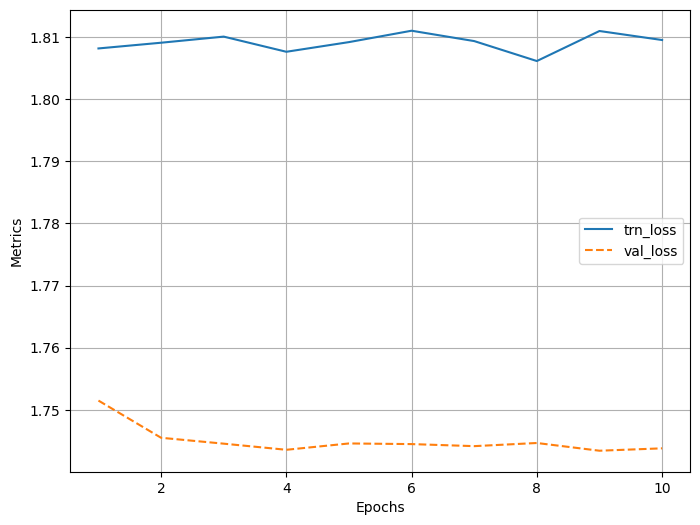

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

100%|██████████| 111/111 [00:00<00:00, 1167.50it/s]


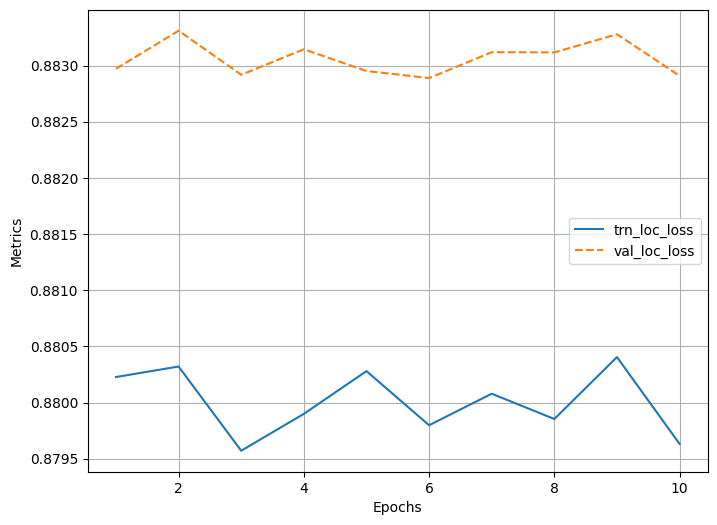

In [ ]:
log.plot_epochs(['trn_loc_loss','val_loc_loss'])


100%|██████████| 111/111 [00:00<00:00, 954.27it/s]


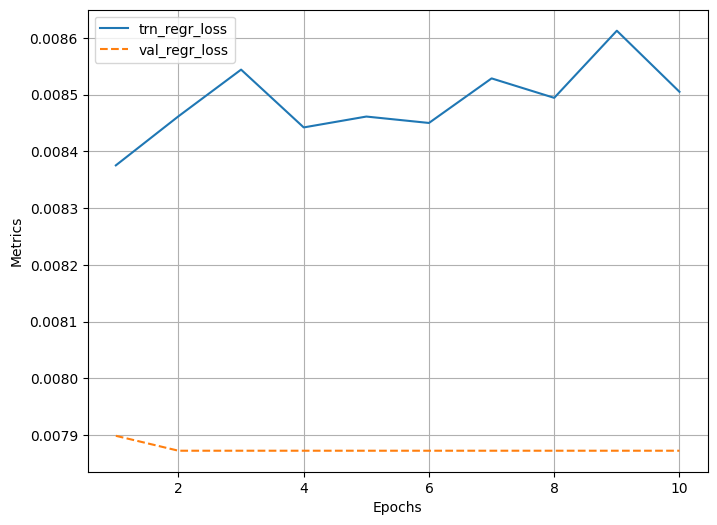

In [ ]:

log.plot_epochs(['trn_regr_loss','val_regr_loss'])


100%|██████████| 111/111 [00:00<00:00, 714.32it/s]


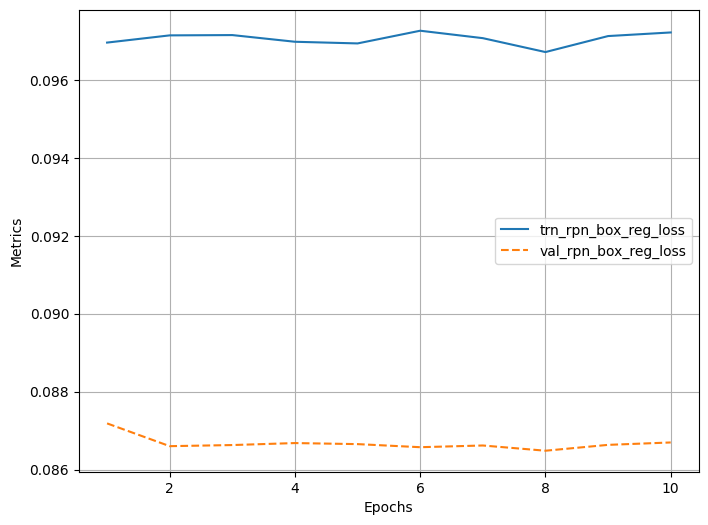

In [ ]:

log.plot_epochs(['trn_rpn_box_reg_loss','val_rpn_box_reg_loss'])


100%|██████████| 111/111 [00:00<00:00, 820.22it/s]


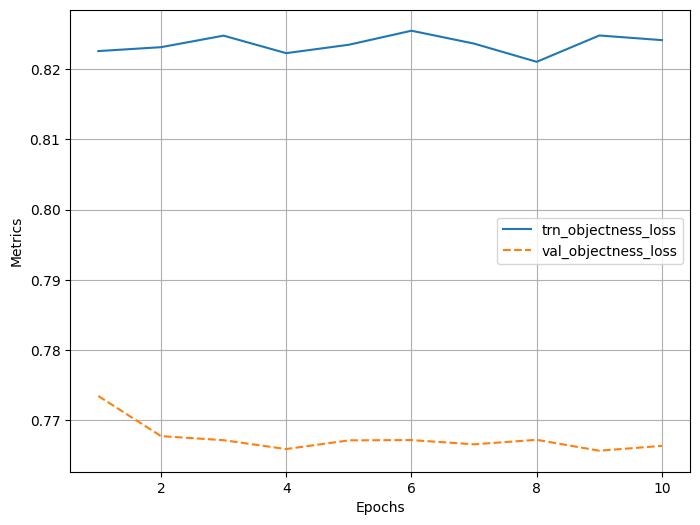

In [ ]:

log.plot_epochs(['trn_objectness_loss','val_objectness_loss'])

In [ ]:
# Save the entire model
torch.save(model_v3.to('cpu').state_dict(), 'gdrive/MyDrive/waste-project/model_v3.pth')

In [ ]:
# Load the saved model
weights_v3_reloaded = torch.load('gdrive/MyDrive/waste-project/model_v3.pth')

# Instantiate your model
my_model_v3 = get_mobilenet_v3().to(device)

# Load the state dictionary into your model
my_model_v3.load_state_dict(weights_v3_reloaded)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 124MB/s]


<All keys matched successfully>

In [ ]:
evaluate_and_display(val_data_loader, my_model_v3, decode_output, target2label, calculate_precision_recall, calculate_mean_iou, custom_show)

Output hidden; open in https://colab.research.google.com to view.

## Overview of ResNet50 with FPN in R-CNN

### GeneralizedRCNNTransform
- **Description**: This initial layer handles the necessary transformations and preprocessing of input images, making them suitable for further processing in the neural network.

### BackboneWithFPN
#### IntermediateLayerGetter
- **Function**: Responsible for extracting feature maps from different stages of the ResNet50 backbone. It includes layers like Conv2d, FrozenBatchNorm2d, ReLU, and MaxPool2d. Sequential blocks of layers then follow, which constitute the core of the ResNet50 architecture.
#### FeaturePyramidNetwork
- **Role**: Enhances the feature extraction process by integrating these feature maps at different scales, improving the detection of objects across various sizes.

### Region Proposal Network (RPN)
#### AnchorGenerator
- **Purpose**: Generates a set of anchor boxes at multiple scales and aspect ratios across the image.
#### RPNHead
- **Function**: Predicts object proposals based on these anchor boxes, with each proposal consisting of an objectness score and bounding box adjustments.

### RoIHeads
#### MultiScaleRoIAlign
- **Description**: Aligns the proposed regions from the RPN to a fixed size, ensuring a consistent input size for the following layers.
#### TwoMLPHead
- **Function**: Processes these aligned regions further through two fully connected layers to extract features for object classification and bounding box regression.
#### FastRCNNPredictor
- **Output**: Provides the final object classification and bounding box coordinates.


In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=8,collate_fn=dumpsite_dataset.collate_fn, shuffle=True)
val_data_loader = DataLoader(val_dataset,collate_fn=dumpsite_dataset.collate_fn, batch_size=16) #32

In [ ]:
model_fpn = get_resnet50_fpn().to(device)
optimizer = torch.optim.SGD(model_fpn.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 10
log = Report(n_epochs)

# Print summary
summary(model_fpn)

Layer (type:depth-idx)                             Param #
├─GeneralizedRCNNTransform: 1-1                    --
├─BackboneWithFPN: 1-2                             --
|    └─IntermediateLayerGetter: 2-1                --
|    |    └─Conv2d: 3-1                            (9,408)
|    |    └─FrozenBatchNorm2d: 3-2                 --
|    |    └─ReLU: 3-3                              --
|    |    └─MaxPool2d: 3-4                         --
|    |    └─Sequential: 3-5                        (212,992)
|    |    └─Sequential: 3-6                        1,212,416
|    |    └─Sequential: 3-7                        7,077,888
|    |    └─Sequential: 3-8                        14,942,208
|    └─FeaturePyramidNetwork: 2-2                  --
|    |    └─ModuleList: 3-9                        984,064
|    |    └─ModuleList: 3-10                       2,360,320
|    |    └─LastLevelMaxPool: 3-11                 --
├─RegionProposalNetwork: 1-3                       --
|    └─AnchorGenerator: 2-3    

Layer (type:depth-idx)                             Param #
├─GeneralizedRCNNTransform: 1-1                    --
├─BackboneWithFPN: 1-2                             --
|    └─IntermediateLayerGetter: 2-1                --
|    |    └─Conv2d: 3-1                            (9,408)
|    |    └─FrozenBatchNorm2d: 3-2                 --
|    |    └─ReLU: 3-3                              --
|    |    └─MaxPool2d: 3-4                         --
|    |    └─Sequential: 3-5                        (212,992)
|    |    └─Sequential: 3-6                        1,212,416
|    |    └─Sequential: 3-7                        7,077,888
|    |    └─Sequential: 3-8                        14,942,208
|    └─FeaturePyramidNetwork: 2-2                  --
|    |    └─ModuleList: 3-9                        984,064
|    |    └─ModuleList: 3-10                       2,360,320
|    |    └─LastLevelMaxPool: 3-11                 --
├─RegionProposalNetwork: 1-3                       --
|    └─AnchorGenerator: 2-3    


### Model Parameters
- **Total Parameters**: The model comprises a significant number of parameters, totaling 41,299,161, with 41,076,761 of these being trainable. This large number of parameters highlights the model's capacity to learn complex features and representations necessary for accurate object detection.


In [ ]:
for epoch in range(n_epochs):
    _n = len(train_data_loader)
    for ix, inputs in enumerate(train_data_loader):
        loss, losses = train_batch(inputs, model_fpn, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(val_data_loader)
    for ix,inputs in enumerate(val_data_loader):
        loss, losses = validate_batch(inputs, model_fpn)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 2.000  trn_loss: 0.080  trn_objectness_loss: 0.003  trn_rpn_box_reg_loss: 0.006  val_rpn_box_reg_loss: 0.006  val_objectness_loss: 0.005  val_loc_loss: 0.037  trn_loc_loss: 0.027  trn_regr_loss: 0.045  val_regr_loss: 0.049  val_loss: 0.097  (7044.09s - 28176.36s remaining)
EPOCH: 4.000  trn_loss: 0.052  trn_objectness_loss: 0.001  trn_rpn_box_reg_loss: 0.005  val_rpn_box_reg_loss: 0.005  val_objectness_loss: 0.007  val_loc_loss: 0.039  trn_loc_loss: 0.015  trn_regr_loss: 0.031  val_regr_loss: 0.047  val_loss: 0.098  (8157.81s - 12236.71s remaining)
EPOCH: 6.000  trn_loss: 0.043  trn_objectness_loss: 0.001  trn_rpn_box_reg_loss: 0.005  val_rpn_box_reg_loss: 0.005  val_objectness_loss: 0.006  val_loc_loss: 0.038  trn_loc_loss: 0.012  trn_regr_loss: 0.026  val_regr_loss: 0.047  val_loss: 0.097  (9265.16s - 6176.77s remaining)
EPOCH: 8.000  trn_loss: 0.037  trn_objectness_loss: 0.001  trn_rpn_box_reg_loss: 0.005  val_rpn_box_reg_loss: 0.005  val_objectness_loss: 0.007  val_loc_loss:

100%|██████████| 111/111 [00:00<00:00, 717.78it/s]


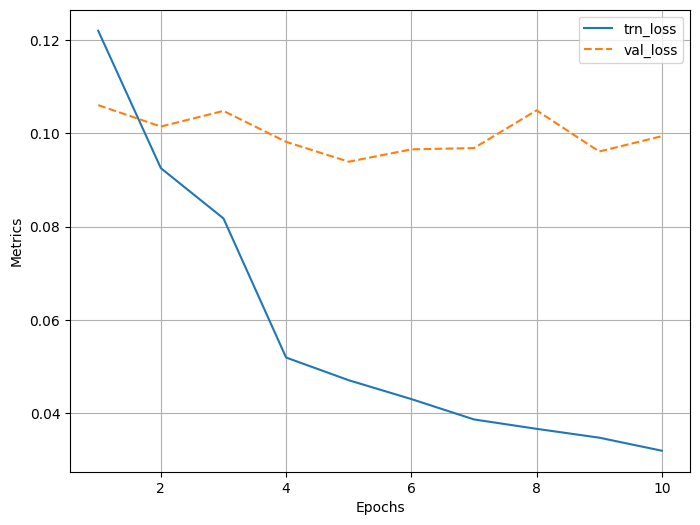

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])


100%|██████████| 111/111 [00:00<00:00, 745.42it/s]


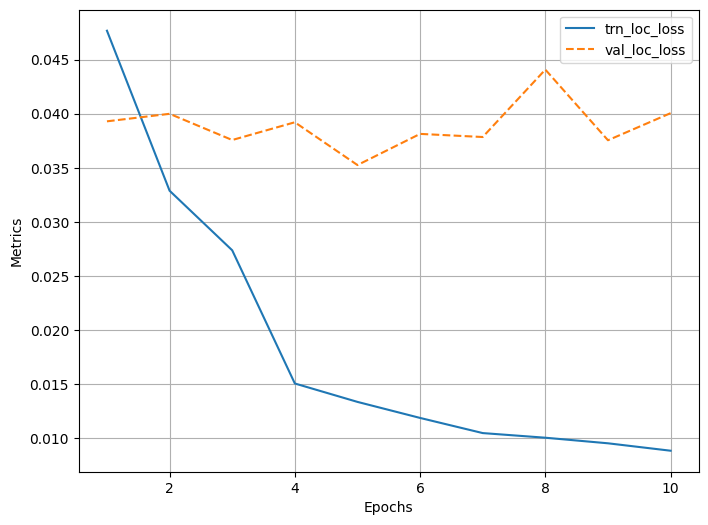

In [ ]:
log.plot_epochs(['trn_loc_loss','val_loc_loss'])


100%|██████████| 111/111 [00:00<00:00, 739.10it/s]


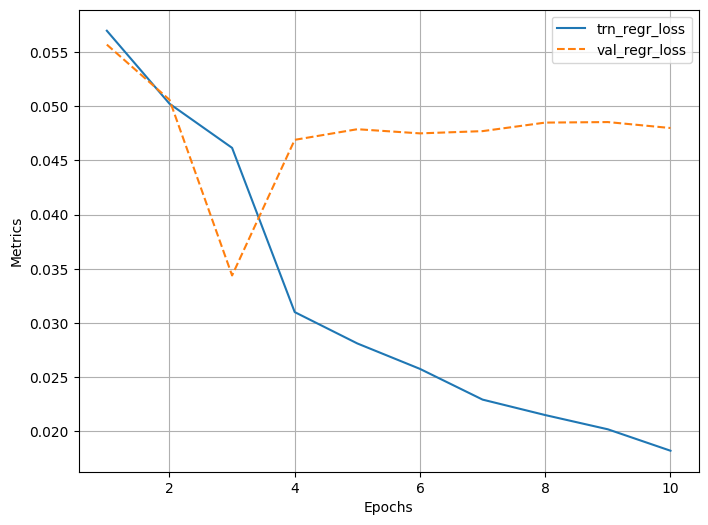

In [ ]:
log.plot_epochs(['trn_regr_loss','val_regr_loss'])


100%|██████████| 111/111 [00:00<00:00, 757.78it/s]


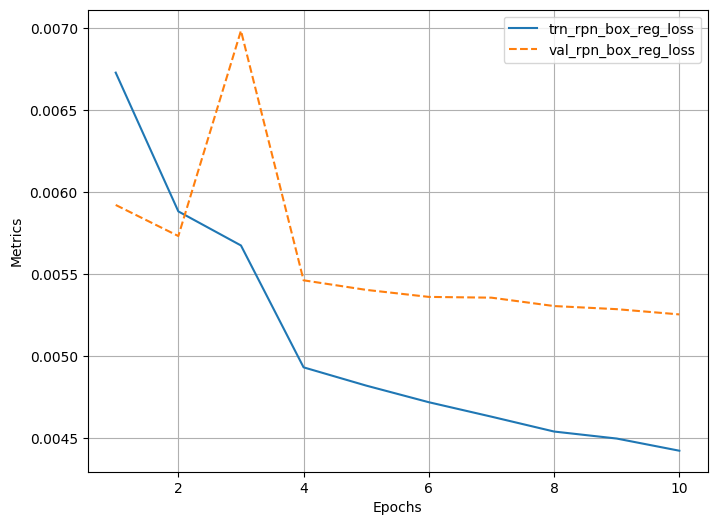

In [ ]:

log.plot_epochs(['trn_rpn_box_reg_loss','val_rpn_box_reg_loss'])


100%|██████████| 111/111 [00:00<00:00, 746.42it/s]


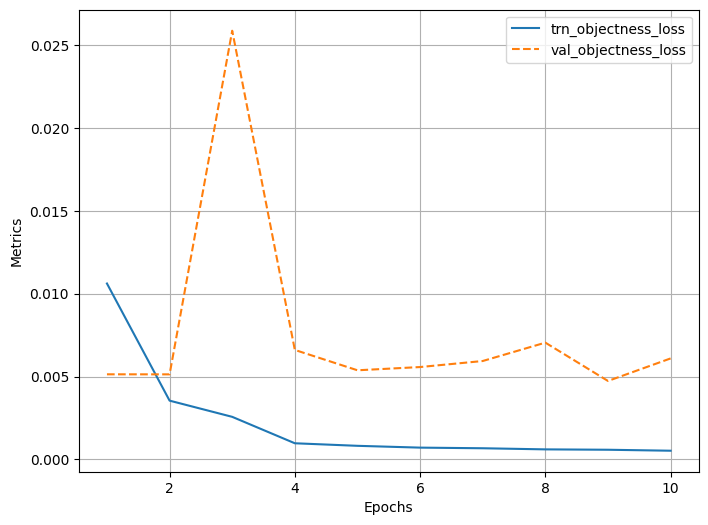

In [ ]:

log.plot_epochs(['trn_objectness_loss','val_objectness_loss'])

In [ ]:
# Save the entire model
torch.save(model_fpn.to('cpu').state_dict(), 'gdrive/MyDrive/waste-project/model_fpn_v2.pth')

In [ ]:
# Load the saved model
weights_fpn_reloaded = torch.load('gdrive/MyDrive/waste-project/model_fpn_v2.pth')

# Instantiate your model
my_model_fpn = get_resnet50_fpn().to(device)

# Load the state dictionary into your model
my_model_fpn.load_state_dict(weights_fpn_reloaded)

<All keys matched successfully>

In [ ]:
evaluate_and_display(val_data_loader, my_model_fpn, decode_output, target2label, calculate_precision_recall, calculate_mean_iou, custom_show)


Output hidden; open in https://colab.research.google.com to view.

## Machine Specifications on Google Colab

The Google Colab machine used, powered by an NVIDIA Tesla V100-SXM2-16GB GPU, is equipped to handle demanding machine learning workloads has tge specification below:

### GPU
- **Model**: NVIDIA Tesla V100-SXM2-16GB
- **Memory**: 16GB (8670MiB used out of 16384MiB)
- **Temperature**: 36°C
- **Power**: 40W (of 300W max)

### Performance
- **CUDA Version**: 12.2


In [ ]:
!nvidia-smi

Tue Dec 26 20:06:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--